<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
《<a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a>》一书的配套代码，作者 <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>代码仓库：<a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp?1" width="100px"></a>
</td>
</tr>
</table>

# 第7章：微调以遵循指令

In [1]:
from importlib.metadata import version

pkgs = [
    "numpy",       # PyTorch & TensorFlow dependency
    "matplotlib",  # Plotting library
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
    "tqdm",        # Progress bar
    "tensorflow",  # For OpenAI's pretrained weights
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

numpy version: 2.3.4
matplotlib version: 3.10.7
tiktoken version: 0.12.0
torch version: 2.9.0
tqdm version: 4.67.1
tensorflow version: 2.20.0


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/01.webp" width=600px>

## 7.1 指令微调简介

- 在第5章，看到预训练LLM涉及一个让模型一次生成一个单词的训练过程
- 因此，预训练的LLM擅长文本补全，但不擅长遵循指令
- 在本章中，让LLM更好地遵循指令

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/02.webp" width=500px>

- 本章涵盖的主题在下图中总结

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/03.webp" width=500px>

## 7.2 为监督式指令微调准备数据集

- 使用一个为本章准备的指令数据集

In [2]:
import json
import os
import requests


def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        text_data = response.text
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


# The book originally used the following code below
# However, urllib uses older protocol settings that
# can cause problems for some readers using a VPN.
# The `requests` version above is more robust
# in that regard.

"""
import urllib

def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data
"""


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


- 从上面的JSON文件加载的`data`列表中的每个条目都是如下形式的字典

In [3]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


- 请注意`'input'`字段可以为空：

In [4]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


- 指令微调通常被称为“监督式指令微调”，因为它涉及在输入-输出对显式提供的数据集上训练模型
- 将条目格式化为LLM的输入有不同方式；下图展示了分别用于训练Alpaca(https://crfm.stanford.edu/2023/03/13/alpaca.html)和Phi-3(https://arxiv.org/abs/2404.14219)LLM的两种示例格式

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/04.webp?2" width=500px>

- 在本章中，使用Alpaca风格的提示格式，它是指令微调的原始提示模板
- 下面，格式化将传递给LLM的输入

In [5]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

- 带有input字段的格式化响应如下所示

In [6]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


- 下面是不含input字段的格式化响应

In [7]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


- 最后，在下一节准备PyTorch数据加载器之前，将数据集划分为训练、验证和测试集

In [8]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [9]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## 7.3 将数据组织成训练批次

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/05.webp?1" width=500px>

- 分几个步骤来完成这个数据集的批处理，如下图所示

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/06.webp?1" width=500px>

- 首先，实现一个`InstructionDataset`类，对数据集中的所有输入进行预分词，类似第6章的`SpamDataset`

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/07.webp?1" width=500px>

In [10]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

- 与第6章类似，希望在一个批次中收集多个训练示例以加快训练；这需要将所有输入填充到相似长度
- 同样与上一章类似，使用`<|endoftext|>` token作为填充token

In [11]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


- 在第6章中，将数据集中所有示例填充到相同长度
  - 这里，采用更复杂的方法，开发一个可以传递给数据加载器的自定义“collate”函数
  - 这个自定义collate函数会把每个批次中的训练示例填充到相同长度（但不同批次可以有不同长度）

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/08.webp?1" width=500px>

In [12]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [13]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/09.webp?1" width=400px>

- 上面，只返回了传给LLM的输入；然而，对于LLM训练，还需要目标值
- 类似于预训练LLM，目标是将输入向右平移1个位置，让LLM学习预测下一个token

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/10.webp?1" width=400px>

In [14]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [15]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


- 接下来，引入一个`ignore_index`值来替换所有填充token ID为一个新值；这个`ignore_index`的目的是可以在损失函数中忽略填充值（稍后详细介绍）

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/12.webp?2" width=500px>

- （此外，引入`allowed_max_length`以便在需要时限制样本长度；如果计划使用比GPT-2模型支持的1024 token上下文更长的自定义数据集，这会很有用）

In [16]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [17]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


- 看看这个用-100替换的作用
- 出于说明目的，假设有一个包含2个类别标签0和1的小分类任务，类似于第6章
- 如果有下面的logits值（模型最后一层的输出），计算以下损失

In [18]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 1st training example
     [-0.5, 1.5]]  # 2nd training example
)
targets_1 = torch.tensor([0, 1])


loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


- 现在，添加另一个训练示例将如预期地影响损失

In [19]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # New 3rd training example
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


- 看看如果用-100替换其中一个示例的类别标签会发生什么

In [20]:
targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


- 如上述所示，这3个训练示例上的结果损失与从2个训练示例计算的损失相同，这意味着交叉熵损失函数忽略了带有-100标签的训练示例
- 默认情况下，PyTorch有`cross_entropy(..., ignore_index=-100)`设置来忽略对应标签-100的示例
- 使用这个-100 `ignore_index`，可以忽略批次中用于将训练示例填充到等长的额外结束文本（填充）token
- 但是，不想忽略第一个结束文本（填充）token实例（50256），因为它可以帮助LLM信号响应何时完成

- 在实践中，屏蔽与指令对应的目标token ID也很常见，如下图所示（这是完成章节后的推荐读者练习）

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/13.webp" width=600px>

&nbsp;
## 7.4 为指令数据集创建数据加载器

- 在本节中，使用`InstructionDataset`类和`custom_collate_fn`函数来实例化训练、验证和测试数据加载器

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/14.webp" width=500px>

- 前一个`custom_collate_fn`函数的另一个细节是，现在直接将数据移动到目标设备（例如GPU），而不是在主训练循环中执行，这提高了效率，因为当将`custom_collate_fn`用作数据加载器的一部分时，它可以作为后台进程执行
- 使用Python的`functools`标准库中的`partial`函数，创建一个新函数，其中原始函数的`device`参数已预填充

In [21]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # Use PyTorch 2.9 or newer for stable mps results
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print("Device:", device)

Device: mps


In [22]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

- 接下来，实例化数据加载器，类似于前几章，除了现在为批处理过程提供自己的collate函数

In [23]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

In [24]:
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

- 看看结果输入和目标批次的维度是什么样的

In [25]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

- 基于上面的输出所见，所有批次的批量大小为8但长度不同，如预期的那样
- 通过打印`inputs`批次中第一个训练示例的内容来再次确认输入包含对应于token ID 50256的`<|endoftext|>`填充token

In [26]:
print(inputs[0])

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,
          985,   576,    13,   198,   198, 21017, 23412,    25,   198,   464,
         5156,   318,   845, 13779,    13,   198,   198, 21017, 18261,    25,
          198,   464,  5156,   318,   355, 13779,   355,   257,  4936,    13,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
       device='mps:0')


- 同样，直观地再次确认目标包含-100占位符token

In [27]:
print(targets[0])

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,   985,
          576,    13,   198,   198, 21017, 23412,    25,   198,   464,  5156,
          318,   845, 13779,    13,   198,   198, 21017, 18261,    25,   198,
          464,  5156,   318,   355, 13779,   355,   257,  4936,    13, 50256,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100],
       device='mps:0')


## 7.5 加载预训练的LLM

- 在本节中，使用与第5章5.5节和第6章6.4节相同的代码加载预训练的GPT模型

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/15.webp?1" width=500px>

- 然而，不是加载最小的1.24亿参数模型，而是加载带有3.55亿参数的中等版本，因为1.24亿模型太小，无法通过指令微调获得定性合理的结果

In [28]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt
# If the `previous_chapters.py` file is not available locally,
# you can import it from the `llms-from-scratch` PyPI package.
# For details, see: https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# E.g.,
# from llms_from_scratch.ch04 import GPTModel
# from llms_from_scratch.ch05 import download_and_load_gpt2, load_weights_into_gpt


BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


- 在下一节开始微调模型之前，看看它在一个验证任务上的表现

In [29]:
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [30]:
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)
# Alternatively:
# from llms_from_scratch.ch05 import (
#    generate,
#    text_to_token_ids,
#    token_ids_to_text
# )


token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

- 注意在前几章中使用的`generate`函数返回合并的输入和输出文本，这在上一节中对于创建可读文本很方便
- 为了隔离响应，可以从`generated_text`开头减去指令的长度

In [31]:
response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


- 如上所示，该模型还不具备遵循指令的能力；它创建了一个"Response"部分，但只是重复原始输入句子以及指令

## 7.6 在指令数据上微调LLM

- 在本节中，微调模型

- 注意可以重用前几章中使用的所有损失计算和训练函数

In [32]:
from previous_chapters import (
    calc_loss_loader,
    train_model_simple
)
# Alternatively:
# from llms_from_scratch.ch05 import (
#    calc_loss_loader,
#    train_model_simple,
# )


- 计算开始训练前的初始训练和验证集损失（如前几章，目标是最小化损失）

In [33]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.8259105682373047
Validation loss: 3.7619349479675295


- 注意训练比前几章更昂贵，因为使用更大的模型（3.55亿而不是1.24亿参数）
- 下面显示了各种设备的运行时间供参考（在此笔记本上运行需要兼容的GPU设备不需要更改代码）

<div style="text-align: left;">
    
| 模型               | 设备                  | 2个epoch运行时间     |
|--------------------|-----------------------|----------------------|
| gpt2-medium (355M) | CPU (M3 MacBook Air)  | 15.78 minutes        |
| gpt2-medium (355M) | GPU (M3 MacBook Air)  | 10.77 minutes        |
| gpt2-medium (355M) | GPU (L4)              | 1.83 minutes         |
| gpt2-medium (355M) | GPU (A100)            | 0.86 minutes         |
| gpt2-small (124M)  | CPU (M3 MacBook Air)  | 5.74 minutes         |
| gpt2-small (124M)  | GPU (M3 MacBook Air)  | 3.73 minutes         |
| gpt2-small (124M)  | GPU (L4)              | 0.69 minutes         |
| gpt2-small (124M)  | GPU (A100)            | 0.39 minutes         |

</div>

- 使用`"gpt2-medium (355M)"`模型运行了此notebook

In [34]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.103
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.944
Ep 1 (Step 000015): Train loss 0.857, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.754, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.800, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.809
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.789
Ep 1 (Step 000050): Train loss 0.663, Val loss 0.783
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.763
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.653, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.535, Val loss 0.732
Ep 1 (Step 000075): Train loss 0.567, Val loss 0.736
Ep 1 (Step 000080): Train loss 0.602, Val loss 0.731
Ep 1 (Step 000085): Train loss 0.513, Val loss 0.715
Ep 1 (Step 000090): Train loss 0.571, Val loss

- 如上述输出所示，模型训练良好，可以根据减少的训练损失和验证损失值来判断
- 此外，基于每个epoch后打印的响应文本，可以看到模型正确遵循指令将输入句子`'The chef cooks the meal every day.'`转换为被动语态`'The meal is cooked every day by the chef.'`（将在后面的章节中正确格式化和评估响应）
- 最后，看一下训练和验证损失曲线

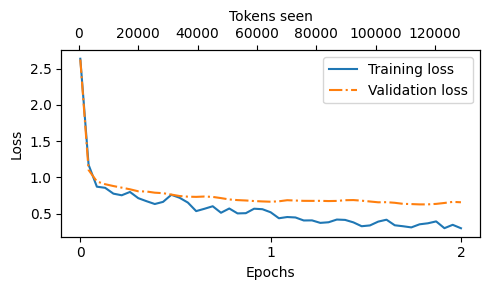

In [35]:
from previous_chapters import plot_losses
# Alternatively:
# from llms_from_scratch.ch05 import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- 如图所示，损失在第一个epoch开始时急剧下降，这意味着模型开始快速学习
- 可以看到轻微过拟合在大约1个训练epoch时开始出现

## 7.7 提取和保存响应

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/18.webp?1" width=500px>

- 在本节中，保存测试集响应以在下一节评分
- 还保存模型的副本以供将来使用
- 但首先，简要查看微调模型生成的响应

In [36]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prej

- 基于测试集指令、给定响应和模型响应所见，模型表现相对较好
- 第一个和最后一个指令的答案显然是正确的
- 第二个答案很接近；模型回答"cumulus cloud"而不是"cumulonimbus"（但是，请注意积云可以发展成能够产生雷暴的积雨云）
- 最重要的是，可以看到模型评估不像上一章那样简单，上一章只需计算正确垃圾邮件/非垃圾邮件类别标签的百分比即可获得分类准确率
- 在实践中，像聊天机器人这样的指令微调LLM通过多种方法评估
  - 短期答案和多选基准测试，如MMLU（"大规模多任务语言理解"，[https://arxiv.org/abs/2009.03300](https://arxiv.org/abs/2009.03300)），测试模型的知识
  - 与其他LLM的人类偏好比较，如LMSYS聊天机器人竞技场（[https://arena.lmsys.org](https://arena.lmsys.org)）
  - 自动对话基准测试，其中使用另一个LLM（如GPT-4）来评估响应，如AlpacaEval（[https://tatsu-lab.github.io/alpaca_eval/](https://tatsu-lab.github.io/alpaca_eval/)）

- 在下一节中，将使用类似于AlpacaEval的方法，并使用另一个LLM来评估模型的响应；但是，将使用自己的测试集而不是使用公开可用的基准数据集
- 为此，将模型响应添加到`test_data`字典中，并将其保存为`"instruction-data-with-response.json"`文件以进行记录，以便可以在需要时在单独的Python会话中加载和分析它

In [37]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|█████████████████████████████████████████| 110/110 [01:08<00:00,  1.60it/s]


- 再次检查其中一个条目，看看响应是否已正确添加到`test_data`字典中

In [38]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a bullet.'}


- 最后，还保存模型以备将来重用

In [39]:
import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Load model via
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

Model saved as gpt2-medium355M-sft.pth


## 7.8 评估微调的LLM

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/19.webp?1" width=500px>

- 在本节中，使用另一个更大的LLM自动评估微调LLM的响应
- 特别是，使用Meta AI的指令微调80亿参数Llama 3模型，该模型可以通过ollama本地运行（[https://ollama.com](https://ollama.com)）
- （或者，如果更喜欢通过OpenAI API使用像GPT-4这样更有能力的LLM，请参阅[llm-instruction-eval-openai.ipynb](../03_model-evaluation/llm-instruction-eval-openai.ipynb)笔记本）

- Ollama是一个高效运行LLM的应用程序
- 它是llama.cpp（[https://github.com/ggerganov/llama.cpp](https://github.com/ggerganov/llama.cpp)）的包装器，它以纯C/C++实现LLM以最大化效率
- 注意它是一个使用LLM生成文本（推理）的工具，而不是训练或微调LLM
- 在运行下面的代码之前，通过访问[https://ollama.com](https://ollama.com)并按照说明安装ollama（例如，点击"下载"按钮并为你的操作系统下载ollama应用程序）

- 对于macOS和Windows用户，点击下载的ollama应用程序；如果它提示你安装命令行使用，说"是"
- Linux用户可以使用ollama网站上提供的安装命令

- 一般来说，在从命令行使用ollama之前，必须启动ollama应用程序或在单独的终端中运行`ollama serve`

---

**注意**：

- 当在终端中运行`ollama serve`如上所述时，可能会遇到错误消息`Error: listen tcp 127.0.0.1:11434: bind: address already in use`
- 如果是这种情况，尝试使用命令`OLLAMA_HOST=127.0.0.1:11435 ollama serve`（如果这个地址也在使用中，尝试将数字递增1直到找到未使用的地址）

---

- 在另一个终端运行ollama应用或`ollama serve`后，在命令行执行下列命令来体验80亿参数的Llama 3模型（该模型占用4.7 GB存储空间，首次执行命令时会自动下载）

```bash
# 8B model
ollama run llama3
```

输出类似如下

```
$ ollama run llama3
pulling manifest
pulling 6a0746a1ec1a... 100% ▕████████████████▏ 4.7 GB
pulling 4fa551d4f938... 100% ▕████████████████▏  12 KB
pulling 8ab4849b038c... 100% ▕████████████████▏  254 B
pulling 577073ffcc6c... 100% ▕████████████████▏  110 B
pulling 3f8eb4da87fa... 100% ▕████████████████▏  485 B
verifying sha256 digest
writing manifest
removing any unused layers
success
```

- 请注意，`llama3`指的是经过指令微调的80亿参数Llama 3模型

- 在ollama中使用`"llama3"`模型（8B参数）需要16 GB内存；如果机器不支持，可以通过设置`model = "phi-3"`尝试更小的3.8B参数phi-3模型，该模型只需8 GB内存

- 或者，如果硬件支持，也可以将`llama3`替换为`llama3:70b`来使用更大的700亿参数Llama 3模型

- 下载完成后，会看到一个命令行提示符，可以与模型聊天

- 尝试类似"What do llamas eat?"的提示，应会返回如下输出

```
>>> What do llamas eat?
Llamas are ruminant animals, which means they have a four-chambered
stomach and eat plants that are high in fiber. In the wild, llamas
typically feed on:
1. Grasses: They love to graze on various types of grasses, including tall
grasses, wheat, oats, and barley.
```


- 可以使用输入`/bye`结束此会话

- 以下代码检查ollama会话是否正确运行，然后再继续使用ollama评估在上一节中生成的测试集响应

In [40]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [41]:
# This cell is optional; it allows you to restart the notebook
# and only run section 7.7 without rerunning any of the previous code
import json
from tqdm import tqdm

file_path = "instruction-data-with-response.json"

with open(file_path, "r") as file:
    test_data = json.load(file)


def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

- 现在，对之前使用的`ollama run`命令的替代方式是通过以下函数在Python中通过其REST API与模型交互
- 在运行此笔记本中的下一个单元格之前，确保ollama仍在运行（前面的代码单元格应该打印`"Ollama running: True"`）
- 接下来，运行以下代码单元格来查询模型

In [42]:
import requests  # noqa: F811
# import urllib.request

def query_model(
    prompt,
    model="llama3",
    # If you used OLLAMA_HOST=127.0.0.1:11435 ollama serve
    # update the address from 11434 to 11435
    url="http://localhost:11434/api/chat"
):
    # Create the data payload as a dictionary
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {     # Settings below are required for deterministic responses
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }

    
    """
    # Convert the dictionary to a JSON formatted string and encode it to bytes
    payload = json.dumps(data).encode("utf-8")

    # Create a request object, setting the method to POST and adding necessary headers
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")

    # Send the request and capture the response
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # Read and decode the response
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data
    """

    # The book originally used the commented-out above, which is based
    # on urllib. It works generally fine, but some readers reported
    # issues with using urlib when using a (company) VPN.
    # The code below uses the requests library, which doesn't seem
    # to have these issues.

    # Send the POST request
    with requests.post(url, json=data, stream=True, timeout=30) as r:
        r.raise_for_status()
        response_data = ""
        for line in r.iter_lines(decode_unicode=True):
            if not line:
                continue
            response_json = json.loads(line)
            if "message" in response_json:
                response_data += response_json["message"]["content"]

    return response_data


model = "llama3"
result = query_model("What do Llamas eat?", model)
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy the sweet taste and texture of fresh hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their daily ration. However, it's essential to provide these grains in moderation, as they can be high in calories.
4. Fruits and vegetables: Llamas enjoy a variety of fruits and veggies, such as apples, carrots, sweet potatoes, and leafy greens like kale or spinach.
5. Minerals: Llamas require access to mineral supplements, which help maintain their overall health and well-being.

In the wild, llamas might also eat:

1. Leaves: They'll munch on leaves from trees and shrubs, including plants like willow, alder, and birch.
2. Bark: In some cases, ll

- 注意如果收到`HTTPError: 404 Client Error: Not Found for url: http://localhost:11434/api/chat`错误，这可能意味着还没有下载`llama3`模型（要下载模型，要么使用UI要么在终端上使用`ollama run llama3`）

- 现在，使用上面定义的`query_model`函数，可以评估微调模型的响应；在前一节中查看的前3个测试集响应上尝试一下

In [43]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
>> I'd rate the model response "The car is as fast as a bullet." an 85 out of 100.

Here's why:

* The response uses a simile correctly, comparing the speed of the car to something else (in this case, a bullet).
* The comparison is relevant and makes sense, as bullets are known for their high velocity.
* The phrase "as fast as" is used correctly to introduce the simile.

The only reason I wouldn't give it a perfect score is that some people might find the comparison slightly less vivid or evocative than others. For example, comparing something to lightning (as in the original response) can be more dramatic and attention-grabbing. However, "as fast as a bullet" is still a strong and effective simile that effectively conveys the idea of the car's speed.

Overall, I think the model did a great job!

-------------------------

Dataset response:
>> The type of cloud typically a

---

**注意：更好的评估提示**

- [一位读者（Ayoosh Kathuria）建议](https://github.com/rasbt/LLMs-from-scratch/discussions/449)一个更长、改进的提示，使用1-5的量表（而不是1到100）并采用评分标准，产生更准确和更少噪声的评估：

- Llama 3模型提供了合理的评估，如果模型不完全正确，它也会给部分分数，可以看到基于"cumulus cloud"答案
- 注意前面的提示返回非常冗长的评估；可以调整提示以生成0到100范围内的整数响应（其中100是最好的）来计算模型的平均分数
- 在M3 MacBook Air笔记本电脑上评估测试集中的110个条目大约需要1分钟

In [44]:
def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores


scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries: 100%|████████████████████████| 110/110 [00:37<00:00,  2.90it/s]

Number of scores: 110 of 110
Average score: 49.45



- 微调的模型达到了50以上的平均分数，可以用它作为参考点来将模型与其他模型进行比较或尝试其他可能改善模型的训练设置
- 注意ollama在跨操作系统时并不完全确定性（截至撰写本文），所以每个人得到的数字可能与上面显示的数字略有不同

- 作为参考，原始的
  - Llama 3 8B基础模型得分58.51
  - Llama 3 8B指令模型得分82.65

## 7.9 结论

### 7.9.1 下一步

- 这标志着本书的最后一章
- 涵盖了LLM开发周期的主要步骤：实现LLM架构、预训练LLM并对其进行微调

## 总结与要点

## 下一步是什么？

- 恭喜完成了这本书；如果正在寻找额外的资源，本GitHub仓库中有几个可能感兴趣的奖励部分
- 奖励材料的完整列表可以在主README的[奖励材料](https://github.com/rasbt/LLMs-from-scratch?tab=readme-ov-file#bonus-material)部分中查看
- 突出显示几个原作者最喜欢的：
  1. [从零开始的直接偏好优化（DPO）用于LLM对齐](../04_preference-tuning-with-dpo/dpo-from-scratch.ipynb)实现了一种流行的偏好调优机制，使本章的模型更接近人类偏好
  2. [从零开始的Llama 3.2（独立笔记本）](../../ch05/07_gpt_to_llama/standalone-llama32.ipynb)，Meta AI流行的Llama 3.2从零开始实现，包括加载官方预训练权重；如果准备进行一些额外的实验，可以用每章中的`Llama3Model`类替换`GPTModel`模型（它应该作为1:1替换工作）
  3. [将GPT转换为Llama](../../ch05/07_gpt_to_llama)包含带有分步指南的代码，解释GPT-2和各种Llama模型之间的差异
  4. [理解嵌入层和线性层之间的区别](../../ch02/03_bonus_embedding-vs-matmul/embeddings-and-linear-layers.ipynb)是一个概念解释，说明在LLM输入阶段使用的PyTorch中的`Embedding`层在数学上等价于应用于独热编码数据的线性层
- 快乐的进一步阅读！